In [1]:
import numpy as np
import pandas as pd
import random
import monkdata as m
import dtree as d
from drawtree_qt5 import drawTree
from IPython.display import Image
from id3 import Id3Estimator, export_text

In [2]:
def compute_entropy(datasets):
    entropy_datasets_matrix = np.zeros((len(datasets), 1))
    for idx_data, dataset in enumerate(datasets):
        entropy_datasets_matrix[idx_data] = round(d.entropy(dataset),3)
    return entropy_datasets_matrix

In [3]:
def entropy_matrix(datasets, attribute_index, max_att_list):
    entropy_matrix = np.zeros((len(datasets), len(m.attributes[attribute_index].values)))
    for idx_data, dataset in enumerate(datasets):
        att = m.attributes[max_att_list[idx_data]]
        for idx_value, value in enumerate(att.values):
            entropy_matrix[idx_data,idx_value] = d.entropy(d.select(dataset, att, value))
    return entropy_matrix

In [4]:
def first_level_split_by_attribute(dataset, attribute_idx):
    attribute_values = m.attributes[attribute_idx].values
    attribute_values_list = [[value_] for value_ in list(attribute_values)]
    dataset_by_attribute = []
    for value in attribute_values:
        dataset_by_attribute.append(d.select(dataset, m.attributes[attribute_idx], value))
    return dataset_by_attribute, attribute_values_list

In [5]:
def second_level_split_by_attribute(attribute_values_list,
                                    maximum_information_gain_matrix, first_split_datasets,
                                    max_att_list):

    flat_values_list = [item for sublist in attribute_values_list for item in sublist]
    max_inf_gain_att_list = maximum_information_gain_matrix.transpose()[0]
    secon_level_split_dict = dict()

    for max_inf_gain_att, flat_value_list, first_split_dataset,max_att in zip(
        max_inf_gain_att_list, flat_values_list, first_split_datasets, max_att_list
    ):
        if max_inf_gain_att == 'NA':
            secon_level_split_dict[flat_value_list] = [[first_split_dataset], []]
            continue
        secon_level_split_dict[flat_value_list] = first_level_split_by_attribute(first_split_dataset, max_att)
    return secon_level_split_dict

In [6]:
def information_gain(datasets):
    information_gain_matrix = np.zeros((len(datasets), len(m.attributes)))
    for idx, dataset in enumerate(datasets):
        for i in range(len(m.attributes)):
            average_gain = round(d.averageGain(dataset, m.attributes[i]),4)
            information_gain_matrix[idx, i] = average_gain
    return information_gain_matrix

In [7]:
def maximum_information_gain(datasets):
    information_gain_matrix = information_gain(datasets)
    maximum_information_gain_matrix = np.zeros((len(datasets),2),dtype=object)
    max_att_list = []
    for i in range(len(datasets)):
        inf_gain_maximum = max(information_gain_matrix[i])
        if inf_gain_maximum == 0.0:
            e = 'NA','NA'
            max_att_list.append(0)
        if inf_gain_maximum != 0:
            x, = np.where(information_gain_matrix[i] == inf_gain_maximum)
            e = m.attributes[int(x)], inf_gain_maximum
            max_att_list.append(int(x))
        maximum_information_gain_matrix[i] = e
    return maximum_information_gain_matrix, max_att_list

In [8]:
def second_level_most_common(secon_level_split_dict):
    most_common_dict = dict()
    for key, values in secon_level_split_dict.items():
        dataset_list, attribute_value_list = values
        attribute_value_list = [item for sublist in attribute_value_list for item in sublist]
        label_dict = dict()
        if len(dataset_list) == 1:
            most_common_dict[key] = d.mostCommon(dataset_list[0])
            continue
        for dataset, attribute_value in zip(dataset_list, attribute_value_list):
            label_dict[attribute_value] = d.mostCommon(dataset)
        most_common_dict[key] = label_dict
    return most_common_dict

In [9]:
def perform_buildTree(datasets):
    datasets_trees = []
    for dataset in datasets:
        datasets_trees.append(d.buildTree(dataset, m.attributes))
    return datasets_trees

In [10]:
def check_correct_incorrect_classification(datasets, test_datasets, datasets_names):
    datasets_trees = perform_buildTree(datasets)
    check = {}
    check_e = np.zeros((len(datasets), 2))
    for i, dataset, dataset_name, dataset_tree, test_dataset in zip(range(len(datasets)),datasets, datasets_names, datasets_trees, test_datasets):   
        correct_classification = round(d.check(dataset_tree, test_dataset),3)
        check[dataset_name] = correct_classification
        err = round(1 - d.check(dataset_tree, dataset),3), round((1 - correct_classification),3)
        check_e[i] = err
    return check, check_e

In [11]:
def partition(data, fraction):
    ldata = list(data)
    random.shuffle(ldata)
    breakPoint = int(len(ldata) * fraction)
    return ldata[:breakPoint], ldata[breakPoint:]

In [12]:
def max_pruning(dataset, percentage):
    part_dict_by_fract = dict()
    
    key_name = 'partition_'+str(percentage)
    part_dict_by_fract[key_name] = partition(dataset, percentage)
    trainnig_data, validation_data = part_dict_by_fract[key_name]
    
    trainnig_tree = d.buildTree(trainnig_data, m.attributes)
    precision_trainning_tree = round(d.check(trainnig_tree, validation_data),3)
    error_trainning_tree = round(1 - precision_trainning_tree,3)

    candidate_tree = trainnig_tree
    candidate_precision = precision_trainning_tree
    candidate_error = error_trainning_tree

    trainning_prunned_tree_list = d.allPruned(trainnig_tree)
    for tree in trainning_prunned_tree_list:  

        precision_prunned_trainning_tree = round(d.check(tree, validation_data),3)
        error_prunned_trainning_tree = round(1 - precision_prunned_trainning_tree, 3)

        if precision_prunned_trainning_tree >= candidate_precision:
            candidate_precision = precision_prunned_trainning_tree
            candidate_tree = tree
            candidate_error = error_prunned_trainning_tree
    return (
        trainnig_tree, precision_trainning_tree, error_trainning_tree,
        candidate_tree, candidate_precision, candidate_error
    )

In [13]:
def max_pruning_iterator(dataset, fraction_list, number_of_iteration=20):
    
    pruned_data_by_fract = dict()
    
    for percentage in fractions_list:
        random_split_results_list = []
        for _ in range(number_of_iteration):
            random_split_results_list.append(list(max_pruning(dataset, percentage)))
            # pruned_data_by_fract[key_name] = max_pruning(dataset, percentage)
        key_name = 'partition_'+str(percentage)    
        pruned_data_by_fract[key_name] = random_split_results_list
    return pruned_data_by_fract


Assignment 0:
======================


>Each one of the datasets has properties which makes
them hard to learn. Motivate which of the three problems is most
dicult for a decision tree algorithm to learn.

## Entropy:

## Assignment 1:

> The file `dtree.py` defines a function entropy which
calculates the entropy of a dataset. Import this file along with the
monks datasets and use it to calculate the entropy of the training
datasets.

1. Entropy of each dataset:

In [14]:
datasets_names = ['MONK-1', 'MONK-2', 'MONK-3']
test_datasets_names = ['monk1test', 'monk2test', 'monk3test']
datasets = [m.monk1, m.monk2, m.monk3]
test_datasets = [m.monk1test, m.monk2test, m.monk3test]

In [15]:
print(np.hstack(([[i] for i in list(datasets_names)], compute_entropy(datasets))))

[['MONK-1' '1.0']
 ['MONK-2' '0.957']
 ['MONK-3' '1.0']]


## Assignment 2:

> Explain entropy for a uniform distribution and a
non-uniform distribution, present some example distributions with
high and low entropy.

## Information Gain:

## Assignment 3:

> Use the function averageGain (defined in `dtree.py`)
to calculate the expected information gain corresponding to each of
the six attributes. Note that the attributes are represented as in-
stances of the class Attribute (defined in monkdata.py) which you
can access via `m.attributes[0]`, ..., `m.attributes[5]`. Based on
the results, which attribute should be used for splitting the examples
at the root node?

1. Information gain for each dataset $S$ by attribute $A \subset (A1, A2, A3, A4, A5, A6)$

In [16]:
#pd.DataFrame(information_gain(datasets), index=datasets_names, columns=attributes_names)
print(information_gain(datasets))

[[0.0753 0.0058 0.0047 0.0263 0.287  0.0008]
 [0.0038 0.0025 0.0011 0.0157 0.0173 0.0062]
 [0.0071 0.2937 0.0008 0.0029 0.2559 0.0071]]


## Assignment 4:

> For splitting we choose the attribute that maximizes
the information gain, Eq.3. Looking at Eq.3 how does the entropy of
the subsets, Sk, look like when the information gain is maximized?
How can we motivate using the information gain as a heuristic for
picking an attribute for splitting? Think about reduction in entropy
after the split and what the entropy implies.

Ask about the attribute which maximizes the expected
reduction of the entropy.

1. We choose the attribute that maximizes the information gain, from where we will split at the root node:

In [17]:
ds_maximum_information_gain, max_att = maximum_information_gain(datasets)
print(np.hstack(([[i] for i in list(datasets_names)], ds_maximum_information_gain)))

[['MONK-1' A5 0.287]
 ['MONK-2' A5 0.0173]
 ['MONK-3' A2 0.2937]]


2. The entropy of the subsets $S_{k(i)}$ for each possible attribute $k$ value $i$.

In [18]:
data_entropy_matrix_by_max_att_nd_value = entropy_matrix(datasets, 4, max_att)
data_entropy_matrix_by_max_att_nd_value

array([[0.        , 0.93831535, 0.94807824, 0.90817835],
       [0.91034806, 1.        , 0.96333555, 0.877962  ],
       [0.91829583, 0.8296071 , 0.37764632, 0.        ]])

3. Information gain 

In [19]:
(compute_entropy(datasets) * np.array([[1,1,1,1]])) - data_entropy_matrix_by_max_att_nd_value

array([[ 1.        ,  0.06168465,  0.05192176,  0.09182165],
       [ 0.04665194, -0.043     , -0.00633555,  0.079038  ],
       [ 0.08170417,  0.1703929 ,  0.62235368,  1.        ]])

## 5. Building Decission Trees:

> Split dataset `monk1` according to the selected attribute using
the function `select` (again, defined in dtree.py)

### First Level Split : MONK1

In [20]:
split_monk1, monk1_values = first_level_split_by_attribute(m.monk1, 4)
maximum_information_gain_monk1_a5, max_att_monk1_a5 = maximum_information_gain(split_monk1)

> Compute the information gains for the nodes on the next level of the tree. Which attributes
should be tested for these nodes?

In [21]:
print(information_gain(split_monk1))
print('   ')
print(np.hstack((monk1_values, maximum_information_gain_monk1_a5)))

[[0.     0.     0.     0.     0.     0.    ]
 [0.0402 0.0151 0.0373 0.0489 0.     0.0258]
 [0.0331 0.0022 0.018  0.0191 0.     0.0451]
 [0.2063 0.0339 0.0259 0.0759 0.     0.0033]]
   
[[1 'NA' 'NA']
 [2 A4 0.0489]
 [3 A6 0.0451]
 [4 A1 0.2063]]


> For the monk1 data draw the decision tree up to the **first two levels** and
assign the majority class of the subsets that resulted from the two splits
to the leaf nodes.

### Second Level Split : MONK1

In [22]:
second_level_split_monk1 = second_level_split_by_attribute(
    monk1_values, maximum_information_gain_monk1_a5, split_monk1, max_att_monk1_a5
    )
second_level_most_common_monk1 = second_level_most_common(second_level_split_monk1)

### Most Common Second Level Split : MONK1

In [23]:
second_level_most_common_monk1

{1: True,
 2: {1: False, 2: False, 3: False},
 3: {1: False, 2: False},
 4: {1: False, 2: False, 3: True}}

### Compare  results with a predefined routine for algorithm ID3.

In [24]:
x = np.array([[sample.attribute[attr] for attr in m.attributes] for sample in m.monk1])
y = np.array([str(sample.positive) for sample in m.monk1])
feature_names_ = ["A1","A2","A3","A4","A5","A6"]

In [25]:
estimator_t = Id3Estimator(max_depth=2)
estimator_t.fit(x, y, check_input=False)
print(export_text(estimator_t.tree_, feature_names_))


A5 1: True (29) 
A5 2
|   A4 1: False (6/5) 
|   A4 2: False (6/1) 
|   A4 3: False (8/5) 
A5 3
|   A6 1: False (10/3) 
|   A6 2: False (9/8) 
A5 4
|   A1 1: False (13/1) 
|   A1 2: False (7/4) 
|   A1 3: True (6/3) 



> Use the function buildTree(data, m.attributes) to build the decision tree.

In [26]:
monk1_tree = d.buildTree(m.monk1, m.attributes, 2)
monk1_tree_full = d.buildTree(m.monk1,m.attributes)

A5(+A4(---)A6(--)A1(--+))


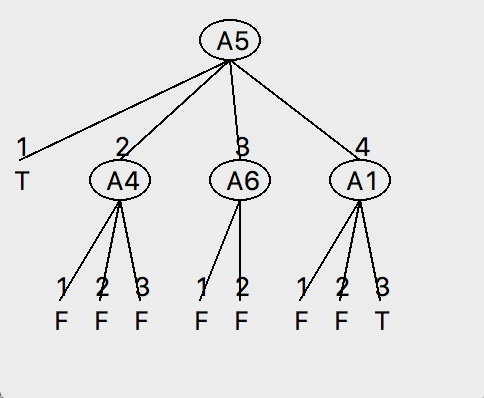

In [27]:
print(monk1_tree)
#drawTree(monk1_tree_full)
Image("monk1_tree_depth2.png")

## Assignment 5:

> Build the full decision trees for all three Monk
datasets using buildTree. Then, use the function check to mea-
sure the performance of the decision tree on both the training and
test datasets.
For example to built a tree for monk1 and compute the performance
on the test data you could use

>`import monkdata as m` <br>
>`import dtree as d`<br>
>`t=d.buildTree(m.monk1, m.attributes);`<br>
>`print(d.check(t, m.monk1test))`<br>

>Compute the train and test set errors for the three Monk datasets
for the full trees. Were your assumptions about the datasets correct?
Explain the results you get for the training and test datasets.

In [28]:
correct_class, incorrect_class = check_correct_incorrect_classification(datasets, test_datasets, datasets_names)

In [29]:
correct_class

{'MONK-1': 0.829, 'MONK-2': 0.692, 'MONK-3': 0.944}

In [30]:
print(np.hstack(([[i] for i in list(datasets_names)], incorrect_class)))

[['MONK-1' '0.0' '0.171']
 ['MONK-2' '0.0' '0.308']
 ['MONK-3' '0.0' '0.056']]


## Assignment 6:

>Explain pruning from a bias variance trade-off perspective.

Randomly partition the original training set into **training** and **validation** set. according to each fraction:

In [31]:
fractions_list = (0.3, 0.4, 0.5, 0.6, 0.7, 0.8)
d = max_pruning_iterator(m.monk1, fractions_list)

In [32]:
d

{'partition_0.3': [[A5(+A4(--A2(+-A1(-++)))A2(A1(+--)A1(-+-)-)A1(-A2(-+-)+)),
   0.805,
   0.195,
   A5(+-A2(A1(+--)A1(-+-)-)A1(-A2(-+-)+)),
   0.828,
   0.172],
  [A5(+A4(A1(-+A2(--+))-A3(+-))A2(A1(+--)+-)A2(A1(+--)A1(-+-)A1(+-+))),
   0.701,
   0.299,
   A5(+A4(A1(-+A2(--+))-A3(+-))A2(A1(+--)+-)-),
   0.713,
   0.287],
  [A5(+A2(-A1(-++)A1(--+))A2(A1(+--)+-)A1(-++)),
   0.713,
   0.287,
   A5(+A2(-A1(-++)A1(--+))A2(A1(+--)+-)-),
   0.747,
   0.253],
  [A5(+A1(A2(+--)-+)A3(+-)A1(-A2(-++)A2(+-+))),
   0.713,
   0.287,
   A5(+A1(A2(+--)-+)-A1(-A2(-++)A2(+-+))),
   0.77,
   0.23],
  [A5(+A1(A2(+--)+A2(--+))A1(A2(+--)--)A2(A1(+--)A1(++-)A1(--+))),
   0.816,
   0.184,
   A5(+A1(A2(+--)+A2(--+))A1(A2(+--)--)A2(-A1(++-)A1(--+))),
   0.816,
   0.184],
  [A5(+A4(+A1(-+-)A1(--+))A4(A1(A2(+--)--)+A1(-+-))A1(A2(+--)A2(-+-)+)),
   0.644,
   0.356,
   A5(+-A4(A1(A2(+--)--)+A1(-+-))A1(A2(+--)A2(-+-)+)),
   0.736,
   0.264],
  [A5(+A1(A2(+--)-A2(--+))A6(A4(A3(+-)--)+)A1(-A2(-+-)+)),
   0.77,
   0.23,

## Assignment 7:

> Evaluate the effect pruning has on the test error for
the `monk1` and `monk3` datasets, in particular determine the optimal
partition into training and pruning by optimizing the parameter
fraction. Plot the classification error on the test sets as a function
of the parameter `fraction` $\subset (0.3, 0.4, 0.5, 0.6, 0.7, 0.8)$
.
Note that the split of the data is random. We therefore need to
compute the statistics over several runs of the split to be able to draw
any conclusions. Reasonable statistics includes mean and a measure
of the spread. Do remember to print axes labels, legends and data
points as you will not pass without them.